In [162]:
import os
import re
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F

In [163]:
# Check if your GPU is requested successfully or not 
assert torch.cuda.device_count() != 0

In [164]:
# from google.colab import drive
# drive.mount('/content/drive')

In [165]:
# path = "/content/drive/MyDrive/ML_data.json"
path = "data/band/ML_data.json"
repr_path = "mdl_data/representations"
df = pd.read_json(path)

# read structure representations
available = sorted(os.listdir(repr_path))
lookup = dict()
for idx, fn in enumerate(available):
    pmg_id = int(fn.split('_')[1])
    lookup[pmg_id] = idx
    
def load_from_id(pmg_id):
    try:
        fn = available[lookup[pmg_id]]
    except KeyError:
        #print(f"Missing representation vector for pymatgen ID: {pmg_id}")
        return float('nan')
    reprpath = os.path.join(repr_path, fn)
    return torch.load(reprpath)

In [166]:
df['PBE_length'] = df['PBE'].apply(lambda x: len(x))
df['HSE_length'] = df['HSE'].apply(lambda x: len(x))
df['pmg_ids'] = df['filename'].apply(lambda x: int(re.findall(r'\d+', x)[0]))
df['struct_feat'] = df['pmg_ids'].apply(load_from_id)

final_df = df.dropna()
final_df

,PBE,HSE,filename,PBE_length,HSE_length,pmg_ids,struct_feat
0,"[-1.51094829, -1.6198644199999999, -1.74032463...","[-1.5519568000000001, -1.63911658, -1.79883221...",PMG_10009.js,1000,1000,10009,"[tensor(0., device='cuda:0'), tensor(0., devic..."
1,"[-13.29682885, -13.29060477, -13.24177159, -13...","[-14.74916008, -14.73420439, -14.67731634, -14...",PMG_10013.js,1000,1000,10013,"[tensor(0., device='cuda:0'), tensor(0., devic..."
2,"[13.39858338, 13.90893838, 14.63546638, 15.242...","[13.97317638, 14.49494138, 15.22412038, 15.817...",PMG_10044.js,1000,1000,10044,"[tensor(0., device='cuda:0'), tensor(0., devic..."
4,"[-4.40062119, -4.24960919, -4.14110819, -3.607...","[-4.7359311900000005, -4.53512419, -4.40628119...",PMG_1004530.js,1000,1000,1004530,"[tensor(0., device='cuda:0'), tensor(0., devic..."
5,"[-0.3670582, -0.3693142, -0.3746912, -0.384274...","[-0.4093312, -0.4093592, -0.41388719999999996,...",PMG_1006118.js,1000,1000,1006118,"[tensor(0., device='cuda:0'), tensor(0., devic..."
...,...,...,...,...,...,...,...
4475,"[-2.71863836, -2.69602234, -2.66825853, -2.731...","[-3.5529553099999998, -3.51685142, -3.49376459...",PMG_999096.js,1000,1000,999096,"[tensor(28.8183, device='cuda:0'), tensor(0., ..."
4476,"[-10.02568924, -10.02499024, -10.02292324, -10...","[-10.62614824, -10.62075224, -10.61630124, -10...",PMG_999274.js,1000,1000,999274,"[tensor(0., device='cuda:0'), tensor(0., devic..."
4477,"[-2.37575091, -2.41262691, -2.43471091, -2.466...","[-2.43747891, -2.46210991, -2.47759691, -2.516...",PMG_9993.js,1000,1000,9993,"[tensor(0., device='cuda:0'), tensor(0., devic..."
4478,"[-22.488213, -22.46114, -22.43402, -22.408054,...","[-22.664806, -22.635401, -22.607898, -22.58518...",PMG_999396.js,1000,1000,999396,"[tensor(20.2207, device='cuda:0'), tensor(0., ..."


In [167]:
X_data = np.vstack(final_df['PBE'].values)
struct_data = torch.vstack(tuple(final_df['struct_feat'].values))
y_data = np.vstack(final_df['HSE'].values)

In [168]:
X_train, X_test, struct_train, struct_test, y_train, y_test = train_test_split(X_data, struct_data, y_data, test_size=0.1, random_state=0)
X_train, X_val, struct_train, struct_val, y_train, y_val = train_test_split(X_train, struct_train, y_train, test_size=0.11, random_state=0)

In [169]:
# Generate dataset 
class BandstructureDataset(Dataset):
    def __init__(self, X, struct, y):
        self.X = torch.Tensor(X)  # store X as a pytorch Tensor
        self.struct = torch.Tensor(struct) # store structure as pytorch Tensor
        self.y = torch.Tensor(y) # store Y as a pytorch Tensor
        self.len=len(self.X)                # number of samples in the data 

    def __getitem__(self, index):
        return self.X[index], self.struct[index], self.y[index] # get the appropriate item

    def __len__(self):
        return self.len

In [170]:
train_data = BandstructureDataset(X_train, struct_train, y_train)# fill in arguments
val_data = BandstructureDataset(X_val, struct_val, y_val)# fill in arguments
test_data = BandstructureDataset(X_test, struct_test, y_test)# fill in arguments

batch_size = 32 # fill in batch size
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)# fill in shuffle argument
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)# fill in shuffle argument
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)# fill in shuffle argument

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3099, 1000)
(384, 1000)
(387, 1000)


In [202]:
include_repr = True
class BandstructureCNN(torch.nn.Module):
    def __init__(self, channels1=128, kernelsize=8, iosize=100, reprsize=100):
        super().__init__()
        self.n_conv = 3
        self.inputsize = iosize
        self.conv1 = nn.Conv1d(1, channels1, kernel_size=kernelsize)
        self.bn1 = nn.BatchNorm1d(channels1)
        self.conv2 = nn.Conv1d(channels1, channels1, kernel_size=kernelsize)
        self.bn2 = nn.BatchNorm1d(channels1)
        self.dropout2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv1d(channels1, channels1, kernel_size=kernelsize)
        self.bn3 = nn.BatchNorm1d(channels1)
        self.fc1 = nn.Linear((self.inputsize - self.n_conv*(kernelsize - 1)) * channels1 + reprsize, self.inputsize * 2)
        self.fc2 = nn.Linear(self.inputsize * 2, self.inputsize)
        self.fc3 = nn.Linear(self.inputsize * 2, self.inputsize)
        
    def forward(self, x, representation):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = F.relu(self.bn2(self.conv2(x1)))
        x22 = F.relu(self.bn3(self.conv3(x2)))
        x3 = torch.concat((torch.flatten(x22, 1, 2), representation * include_repr), axis=1) # concat repr
        x4 = F.leaky_relu(self.fc1(x3))
        x5 = torch.concat((F.leaky_relu(self.fc2(x4)), x.squeeze()), axis=1) # residual connection
        x6 = self.fc3(x5)
        return x6

device = 'cuda'
model = BandstructureCNN().to(device)
for batch in train_dataloader:
    X, struct, Y = batch
    X = X.to(device)[:,500:600].unsqueeze(1)
    out = model(X, struct)
    print(out.shape)
    break

In [203]:
# device to train on
device = 'cuda:0'
# define your model
model = BandstructureCNN().to(device)

# define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, verbose=True)

In [204]:
def train(model, dataloader, optimizer, device):
    
    '''
    A function train on the entire dataset for one epoch .
    
    Args: 
        model (torch.nn.Module): your model from before 
        dataloader (torch.utils.data.DataLoader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer(()): optimizer object to interface gradient calculation and optimization 
        device (str): Your device (usually 'cuda:0' for your GPU)
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''

    epoch_loss = []
    model.train() # Set model to training mode 
    
    for batch in dataloader:    
        X, struct, y = batch
        X = X.to(device)[:,500:600].unsqueeze(1)
        struct = struct.to(device)
        y = y.to(device)[:,500:600].unsqueeze(1)
        
        # train your model on each batch here 
        y_pred = model(X, struct)
        
        loss = nn.functional.mse_loss(y_pred, y.squeeze(1))
        epoch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.array(epoch_loss).mean()


def validate(model, dataloader, device):
    
    '''
    A function validate on the validation dataset for one epoch .
    
    Args: 
        model (torch.nn.Module): your model for before 
        dataloader (torch.utils.data.DataLoader): DataLoader object for the validation data
        device (str): Your device (usually 'cuda:0' for your GPU)
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    
    val_loss = []
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            X, struct, y = batch
            X = X.to(device)[:,500:600].unsqueeze(1)
            struct = struct.to(device)
            y = y.to(device)[:,500:600].unsqueeze(1)
            
            # validate your model on each batch here 
            y_pred = model(X, struct)

            loss = nn.functional.mse_loss(y_pred, y.squeeze(1))
            val_loss.append(loss.item())
            
    return np.array(val_loss).mean()


In [208]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(400):
    
    # Compute train your model on training data
    epoch_loss = train(model, train_dataloader, optimizer,  device=device)
    
    # Validate your on validation data 
    val_loss = validate(model, val_dataloader, device=device) 
    scheduler.step(val_loss)
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    if epoch % 10 == 0:
        print(epoch, epoch_loss, val_loss)

epoch train loss validation loss
0 0.0815116928688721 0.6660405794003358
10 0.04088047940821685 0.5795311693412563
Epoch 00114: reducing learning rate of group 0 to 5.0000e-04.
20 0.022293758060130262 0.5806654073918859
30 0.022411830180814277 0.5954893086260805
40 0.027663398351635515 0.5942781950968007
50 0.028477164033377907 0.6463747077311078
60 0.019093931479782788 0.6497554488790532
Epoch 00165: reducing learning rate of group 0 to 2.5000e-04.
70 0.011899038755632554 0.679848658076177
80 0.007939411041605258 0.6995863206684589
90 0.009286353808645275 0.6817560540512204
100 0.007929442644829756 0.6669404537727436
110 0.007551379122569696 0.7393179087278744
Epoch 00216: reducing learning rate of group 0 to 1.2500e-04.
120 0.00611715945751243 0.6831231055160364
130 0.0054024148242759334 0.6848545121029019
140 0.0055201387911382105 0.6859837402589619
150 0.005098322807263928 0.6633519626532992
160 0.004692581669456258 0.6695008245296776
Epoch 00267: reducing learning rate of group 0 

In [209]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

model.eval()
Xs = []
y_preds = []
y_trues = []
with torch.no_grad():    
    for batch in test_dataloader: # probably a more efficient way to do this? not sure
        X, struct, y = batch
        Xs.append(X[:,500:600])
        X = X.to(device)[:,500:600].unsqueeze(1)
        struct = struct.to(device)
        y = y.to(device)[:,500:600].unsqueeze(1)
        y_pred = model(X, struct).detach().cpu().numpy()
        y_true = y.squeeze(1).detach().cpu().numpy()
        y_preds.append(y_pred)
        y_trues.append(y_true)

X = np.concatenate(Xs, axis=0)
y_t = np.concatenate(y_trues, axis=0)
y_p = np.concatenate(y_preds, axis=0)

mean_absolute_error(y_t, y_p)

0.2356918

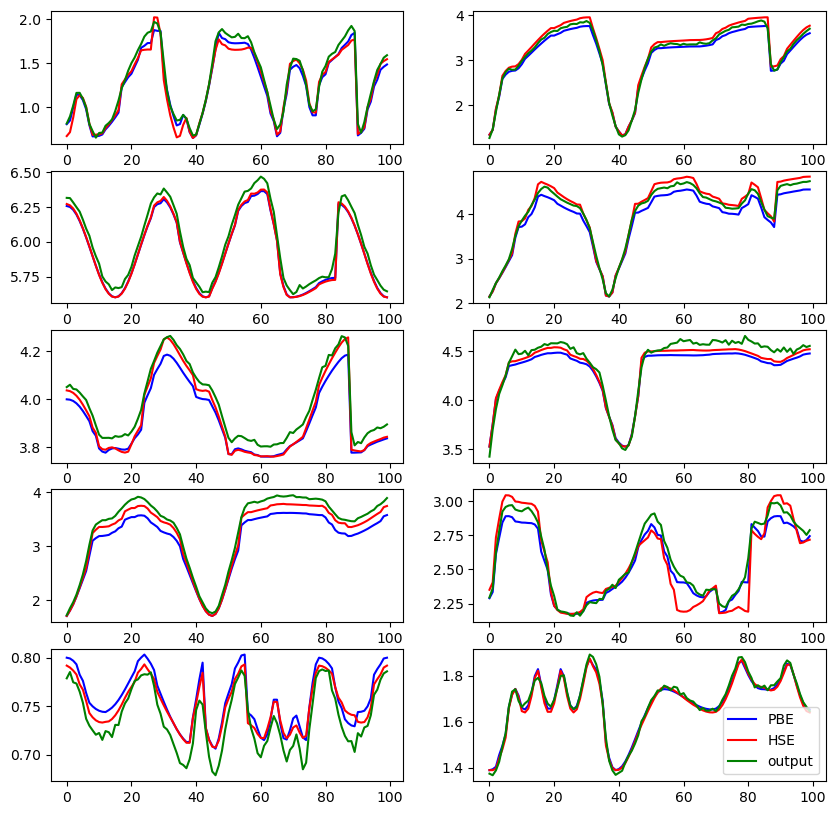

In [210]:
fig, axes = plt.subplots(5,2, figsize=(10,10))
for index in range(10):
    X_band = X[index].squeeze()
    y_true_band = y_t[index]
    y_pred_band = y_p[index]
    axes[index%5][index//5].plot(X_band,'b-',label='PBE')
    axes[index%5][index//5].plot(y_true_band, 'r-',label='HSE')
    axes[index%5][index//5].plot(y_pred_band,'g-',label='output')
plt.legend()
plt.show()